In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Estimate global histone modification changes between cell types

- Retrieve number of properly paired mapped reads with mapq > 5 for each bam file in NPC48 and mESC;
- Import data into dataframe;
- Compute global log2 fold-changes for each histone modification using the following double ratio:

\begin{equation}
L2FC_\text{ histone mark} = \frac{\frac{\text{ChIP reads in sample A}}{\text{Input reads in sample A}}}{\frac{\text{ChIP reads in sample B}}{\text{Input reads in sample B}}}
\end{equation}

- Plot results

In [3]:
%%bash

### Retrieve number of properly paired mapped reads with mapq > 5 for each bam file in NPC48 ###

for i in /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/*rep*.bam; do \
echo $(basename $i) | tr "\n" "\t" >> ../INTERMEDIATE_FILES/NPC48h_reads.txt; sambamba view -F "not (unmapped or mate_is_unmapped) and mapping_quality >= 5 and proper_pair" -c $i >> ../INTERMEDIATE_FILES/NPC48h_reads.txt; done


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13

In [4]:
%%bash

### Retrieve number of properly paired mapped reads with mapq > 5 for each bam file in mESC ###

for i in /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/*rep*.bam; do \
echo $(basename $i) | tr "\n" "\t" >> ../INTERMEDIATE_FILES/mESC_reads.txt; sambamba view -F "not (unmapped or mate_is_unmapped) and mapping_quality >= 5 and proper_pair" -c $i >> ../INTERMEDIATE_FILES/mESC_reads.txt; done


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13.0 / DMD v2.083.1 / LLVM7.0.1 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.13

In [2]:
### Import data into DF ###

df_NPC48h = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_reads.txt",sep="\t",header=None, names=["experiment","read_count"])
df_mESC = pd.read_csv("../INTERMEDIATE_FILES/mESC_reads.txt",sep="\t",header=None, names=["experiment","read_count"])

frames = [df_mESC, df_NPC48h]
df = pd.concat(frames)
df.index = df.experiment.values

df["mark"] = [i.split(".")[0].split("_")[-2] for i in list(df["experiment"])]
df["sample"] = ["_".join(i.split(".")[0].split("_")[:3]) for i in list(df["experiment"])]
df["sample"].replace({"iNPC_DMSO_rep1":"NPC48h_DMSO_rep1",
                      "iNPC_DMSO_rep2":"NPC48h_DMSO_rep2",
                      "iNPC_EPZ_rep1":"NPC48h_EPZ_rep1",
                      "iNPC_EPZ_rep2":"NPC48h_EPZ_rep2"},
                      inplace = True)
df["treatment"] = [l.split("_")[1] for l in list(df["sample"])]
df["cell_type"] = [l.split("_")[0] for l in list(df["sample"])]
df["replicate"] = [l.split("_")[2] for l in list(df["sample"])]
df.sort_values(by=["mark","sample"], inplace = True)

df["mark"].loc[df["mark"] == "rep1"] = "Input"
df["mark"].loc[df["mark"] == "rep2"] = "Input"

df

/home/ferrari/.local/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,experiment,read_count,mark,sample,treatment,cell_type,replicate
iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,7173500,H3K27ac,NPC48h_DMSO_rep1,DMSO,NPC48h,rep1
iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,15413162,H3K27ac,NPC48h_DMSO_rep2,DMSO,NPC48h,rep2
iNPC_EPZ_rep1_H3K27ac_merged.filtered.bam,iNPC_EPZ_rep1_H3K27ac_merged.filtered.bam,12537314,H3K27ac,NPC48h_EPZ_rep1,EPZ,NPC48h,rep1
iNPC_EPZ_rep2_H3K27ac_merged.filtered.bam,iNPC_EPZ_rep2_H3K27ac_merged.filtered.bam,12242438,H3K27ac,NPC48h_EPZ_rep2,EPZ,NPC48h,rep2
mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,59061198,H3K27ac,mESC_DMSO_rep1,DMSO,mESC,rep1
...,...,...,...,...,...,...,...
mESC_EPZ_rep1_Input.filtered.bam,mESC_EPZ_rep1_Input.filtered.bam,20406582,Input,mESC_EPZ_rep1,EPZ,mESC,rep1
iNPC_DMSO_rep2_Input.filtered.bam,iNPC_DMSO_rep2_Input.filtered.bam,14102368,Input,NPC48h_DMSO_rep2,DMSO,NPC48h,rep2
iNPC_EPZ_rep2_Input.filtered.bam,iNPC_EPZ_rep2_Input.filtered.bam,15944970,Input,NPC48h_EPZ_rep2,EPZ,NPC48h,rep2
mESC_DMSO_rep2_Input.filtered.bam,mESC_DMSO_rep2_Input.filtered.bam,27944858,Input,mESC_DMSO_rep2,DMSO,mESC,rep2


In [3]:
### FINALIZE DATAFRAME ###

df_sorted = df.reindex(list(df.index)[:56] + ["iNPC_DMSO_rep1_Input.filtered.bam","iNPC_DMSO_rep2_Input.filtered.bam",
                                              "iNPC_EPZ_rep1_Input.filtered.bam","iNPC_EPZ_rep2_Input.filtered.bam",
                          "mESC_DMSO_rep1_Input.filtered.bam","mESC_DMSO_rep2_Input.filtered.bam",
                          "mESC_EPZ_rep1_Input.filtered.bam","mESC_EPZ_rep2_Input.filtered.bam"])
df_wt = df_sorted.loc[df_sorted.treatment == 'DMSO']

df_wt

,experiment,read_count,mark,sample,treatment,cell_type,replicate
iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,7173500,H3K27ac,NPC48h_DMSO_rep1,DMSO,NPC48h,rep1
iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,15413162,H3K27ac,NPC48h_DMSO_rep2,DMSO,NPC48h,rep2
mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,59061198,H3K27ac,mESC_DMSO_rep1,DMSO,mESC,rep1
mESC_DMSO_rep2_H3K27ac_merged.filtered.bam,mESC_DMSO_rep2_H3K27ac_merged.filtered.bam,67575378,H3K27ac,mESC_DMSO_rep2,DMSO,mESC,rep2
iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam,iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam,14046792,H3K27me3,NPC48h_DMSO_rep1,DMSO,NPC48h,rep1
iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam,iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam,24082300,H3K27me3,NPC48h_DMSO_rep2,DMSO,NPC48h,rep2
mESC_DMSO_rep1_H3K27me3_merged.filtered.bam,mESC_DMSO_rep1_H3K27me3_merged.filtered.bam,48251122,H3K27me3,mESC_DMSO_rep1,DMSO,mESC,rep1
mESC_DMSO_rep2_H3K27me3_merged.filtered.bam,mESC_DMSO_rep2_H3K27me3_merged.filtered.bam,43956898,H3K27me3,mESC_DMSO_rep2,DMSO,mESC,rep2
iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam,iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam,19536310,H3K36me3,NPC48h_DMSO_rep1,DMSO,NPC48h,rep1
iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam,iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam,31317062,H3K36me3,NPC48h_DMSO_rep2,DMSO,NPC48h,rep2


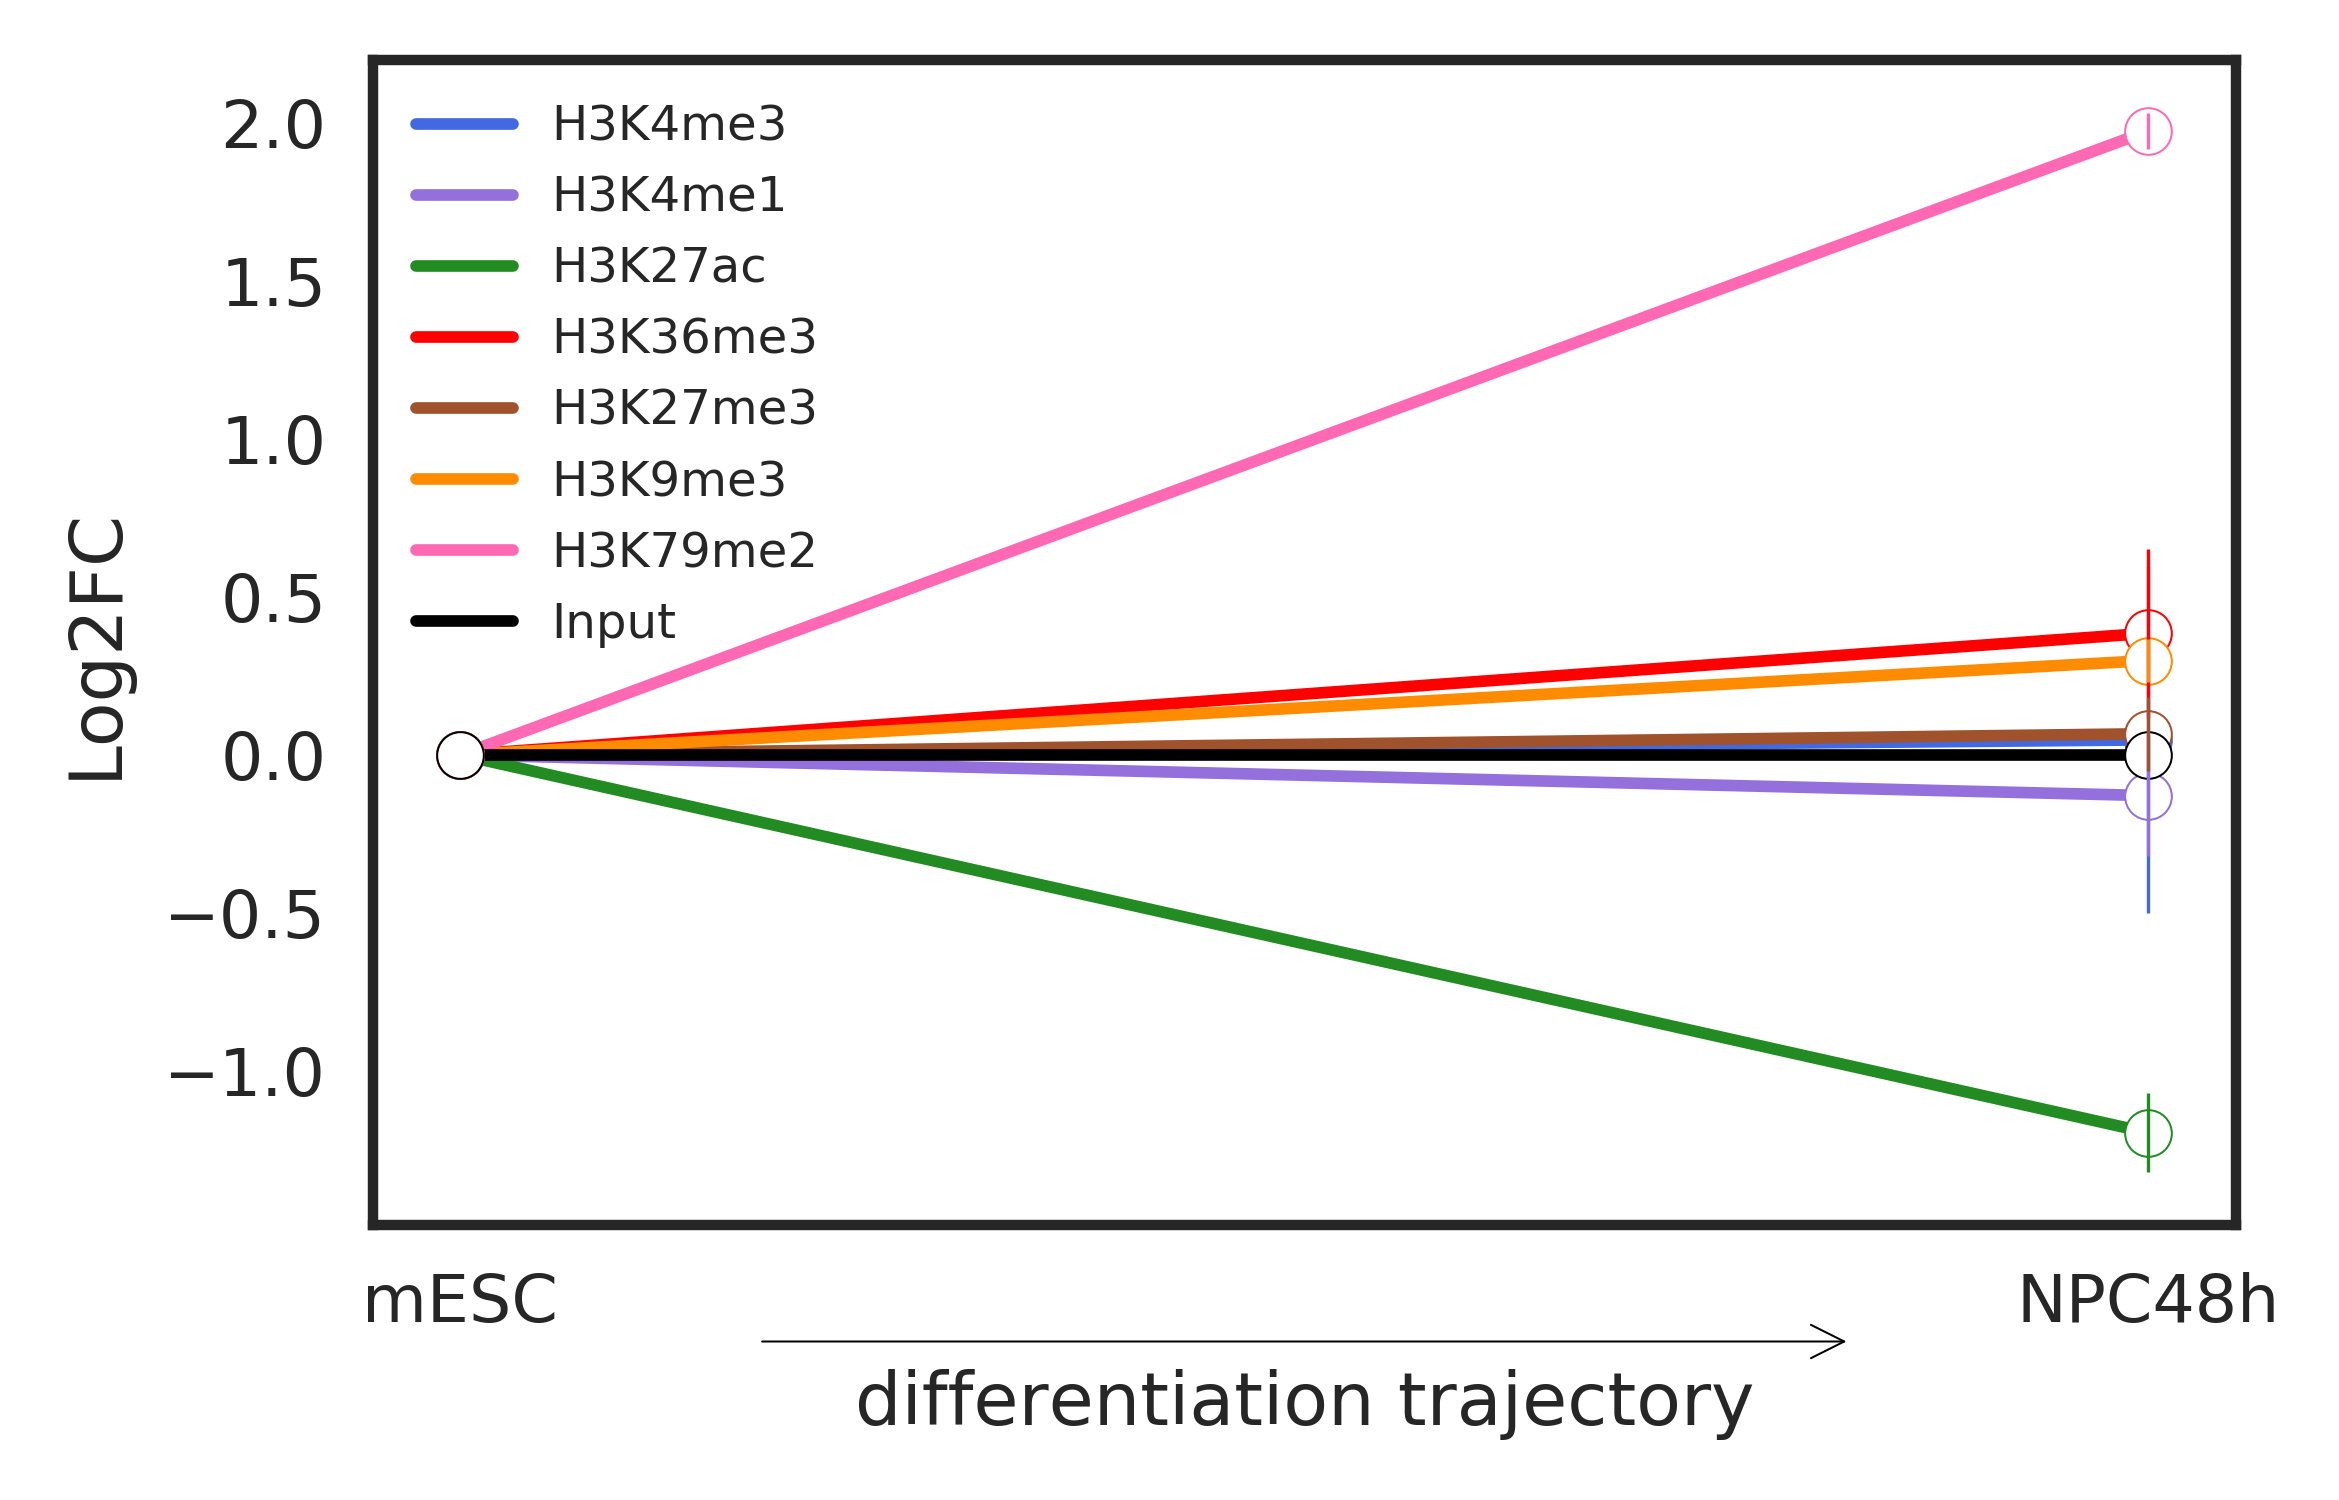

In [5]:
### COMPUTE DOUBLE RATIOS AND PLOT ###

plt.figure(dpi=600, figsize=(4,2.6))

cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink',
      "Input":'k'}

for i in ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K27me3","H3K9me3","H3K79me2","Input"]:#set(list(df_wt.mark)):
    
    inp = df_wt.loc[df_wt.mark == "Input"][["read_count"]]

    markss = df_wt.loc[df_wt.mark == i][["read_count"]]

    norm = markss.values/inp.values
   
    ratios = []
    for k in norm:
        a = list()
        for j in norm:
            a.append(k/j)
        ratios.append(list(a))

    iNPC = np.mean(np.log2(np.array(ratios)[:2,2:]))
    iNPC_std = np.std(np.log2(np.array(ratios)[:2,2:]))
    
    #mESC = np.mean(np.log2(np.array(ratios)[2:,:2]))

    plt.plot([0,1],[0,iNPC], label = i, zorder=0, color=cols[i])
    plt.errorbar([1],[iNPC],  yerr=iNPC_std, linewidth=0.4, capsize=0, color=cols[i])
    plt.scatter([0,1],[0,iNPC], zorder=1, edgecolor=cols[i], alpha=1, facecolor='white')
    
    
    plt.xticks(np.array([0,1]), ["mESC","NPC48h"])

    plt.legend(fontsize="xx-small", frameon=False)

plt.ylabel("Log2FC")
plt.xlabel("differentiation trajectory")
plt.annotate('', xy=(0.2, -0.1), xycoords='axes fraction', xytext=(0.8, -0.1), 
            arrowprops=dict(arrowstyle="<-", color='k'))

plt.tight_layout()

plt.savefig("../FIGURES/GlobalFoldChanges_allMarks.pdf")

# Compute RELACS double ratios on annotated genomic regions associated with local histone PTM enrichment 

- Define genomic regions of interest:
    - H3K4me3 and H3K27ac : TSS +- 2000 bp;
    - H3K79me2 : TSS +3000;
    - H3K36me3 : TES -300;
- Retrieve counts and merge replicates;
- Compute double ratios for each locus and plot (MA plot)

In [17]:
%%bash

### EXTRACT GENOMIC FEATURES OF INTEREST ###

extract_from_gtf.py -o ../INPUT_DATA/ -f TSS -w gene -prot_cod -b_tss 2000 -a_tss 2000 \
/data/manke/group/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf

mv ../INPUT_DATA/TSS.bed ../INPUT_DATA/TSS_2kbplmi.bed

extract_from_gtf.py -o ../INPUT_DATA/ -f genes -w gene -prot_cod \
/data/manke/group/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf

mv ../INPUT_DATA/genes.bed ../INPUT_DATA/Protein_coding_genes.bed

extract_from_bed.py  -f TSS -b_tss 0 -a_tss 3000 -l ../INPUT_DATA/Protein_coding_genes.bed
mv TSS.bed ../INPUT_DATA/3kb_DownTSS_ProteinCoding.bed

extract_from_bed.py -f TES -b_tes 3000 -a_tes 0 -l ../INPUT_DATA/Protein_coding_genes.bed
mv TES.bed ../INPUT_DATA/3kb_UpTES_ProteinCoding.bed

Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=500, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=1000, FEATURE=['genes'], PROTEIN_CODING=True, from_what='gene', gtf_file='/data/manke/group/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf', out_dir='../DATA/', verbose=False)
Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=3000, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=0, FEATURE=['TSS'], bed_file='../DATA/Protein_coding_genes.bed', limit=True, out_dir='./', verbose=False)
Namespace(AFTER_GENE=0, AFTER_TES=0, AFTER_TSS=500, BEFORE_GENE=0, BEFORE_TES=3000, BEFORE_TSS=1000, FEATURE=['TES'], bed_file='../DATA/Protein_coding_genes.bed', limit=True, out_dir='./', verbose=False)


In [18]:
%%bash

### RETRIEVE COUNTS FOR EACH HISTONE MODIFICATION ###

mark="H3K36me3"
bed="../INPUT_DATA/3kb_UpTES_ProteinCoding.bed"

multiBamSummary BED-file \
--BED $bed \
-b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_rep*_Input.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_rep*_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.npz" \
--outRawCounts ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.counts" \
--smartLabels \
-p 20 \
-bl /data/repository/organisms/GRCm38_ensembl/DKFZ/GRCm38_General_readAttractingRegions.UseThisOne.bed \
-e \
--samFlagInclude 2 



mark="H3K79me2"
bed="../INPUT_DATA/3kb_DownTSS_ProteinCoding.bed"

multiBamSummary BED-file \
--BED $bed \
-b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_rep*_Input.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_rep*_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.npz" \
--outRawCounts ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.counts" \
--smartLabels \
-p 20 \
-bl /data/repository/organisms/GRCm38_ensembl/DKFZ/GRCm38_General_readAttractingRegions.UseThisOne.bed \
-e \
--samFlagInclude 2 



mark="H3K4me3"
bed="../INPUT_DATA/TSS_2kbplmi.bed"

multiBamSummary BED-file \
--BED $bed \
-b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_rep*_Input.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_rep*_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.npz" \
--outRawCounts ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.counts" \
--smartLabels \
-p 20 \
-bl /data/repository/organisms/GRCm38_ensembl/DKFZ/GRCm38_General_readAttractingRegions.UseThisOne.bed \
-e \
--samFlagInclude 2 



mark="H3K27ac"
bed="../INPUT_DATA/TSS_2kbplmi.bed"

multiBamSummary BED-file \
--BED $bed \
-b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_$mark"_merged.filtered.bam" \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_rep*_Input.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_rep*_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.npz" \
--outRawCounts ../INTERMEDIATE_FILES/$mark"_NPC48h_vs_mESC.counts" \
--smartLabels \
-p 20 \
-bl /data/repository/organisms/GRCm38_ensembl/DKFZ/GRCm38_General_readAttractingRegions.UseThisOne.bed \
-e \
--samFlagInclude 2 

Number of bins found: 21962
Number of bins found: 21965
Number of bins found: 21969
Number of bins found: 21969


In [6]:
### import raw counts ###

mark="H3K27ac"
# bed="../DATA/TSS_2kbplmi.bed"

counts_k27ac = pd.read_csv("../INTERMEDIATE_FILES/{}_NPC48h_vs_mESC.counts".format(mark),
                     sep="\t",header=0, 
                     names=["chr","start","end",
                            "ESC_DMSO_1","ESC_DMSO_2","ESC_EPZ_1","ESC_EPZ_2",
                            "NPC48h_DMSO_1","NPC48h_DMSO_2","NPC48h_EPZ_1","NPC48h_EPZ_2",
                            "ESC_DMSO_1_INP","ESC_DMSO_2_INP","ESC_EPZ_1_INP","ESC_EPZ_2_INP",
                            "NPC48h_DMSO_1_INP","NPC48h_DMSO_2_INP","NPC48h_EPZ_1_INP","NPC48h_EPZ_2_INP"])

mark="H3K4me3"
# bed="../DATA/TSS_2kbplmi.bed"

counts_k4me3 = pd.read_csv("../INTERMEDIATE_FILES/{}_NPC48h_vs_mESC.counts".format(mark),
                     sep="\t",header=0, 
                     names=["chr","start","end",
                            "ESC_DMSO_1","ESC_DMSO_2","ESC_EPZ_1","ESC_EPZ_2",
                            "NPC48h_DMSO_1","NPC48h_DMSO_2","NPC48h_EPZ_1","NPC48h_EPZ_2",
                            "ESC_DMSO_1_INP","ESC_DMSO_2_INP","ESC_EPZ_1_INP","ESC_EPZ_2_INP",
                            "NPC48h_DMSO_1_INP","NPC48h_DMSO_2_INP","NPC48h_EPZ_1_INP","NPC48h_EPZ_2_INP"])

mark="H3K79me2"
# bed="../DATA/3kb_DownTSS_ProteinCoding.bed"

counts_k79me2 = pd.read_csv("../INTERMEDIATE_FILES/{}_NPC48h_vs_mESC.counts".format(mark),
                     sep="\t",header=0, 
                     names=["chr","start","end",
                            "ESC_DMSO_1","ESC_DMSO_2","ESC_EPZ_1","ESC_EPZ_2",
                            "NPC48h_DMSO_1","NPC48h_DMSO_2","NPC48h_EPZ_1","NPC48h_EPZ_2",
                            "ESC_DMSO_1_INP","ESC_DMSO_2_INP","ESC_EPZ_1_INP","ESC_EPZ_2_INP",
                            "NPC48h_DMSO_1_INP","NPC48h_DMSO_2_INP","NPC48h_EPZ_1_INP","NPC48h_EPZ_2_INP"])

mark="H3K36me3"
# bed="../DATA/TES_3kb.bed"

counts_k36me3 = pd.read_csv("../INTERMEDIATE_FILES/{}_NPC48h_vs_mESC.counts".format(mark),
                     sep="\t",header=0, 
                     names=["chr","start","end",
                            "ESC_DMSO_1","ESC_DMSO_2","ESC_EPZ_1","ESC_EPZ_2",
                            "NPC48h_DMSO_1","NPC48h_DMSO_2","NPC48h_EPZ_1","NPC48h_EPZ_2",
                            "ESC_DMSO_1_INP","ESC_DMSO_2_INP","ESC_EPZ_1_INP","ESC_EPZ_2_INP",
                            "NPC48h_DMSO_1_INP","NPC48h_DMSO_2_INP","NPC48h_EPZ_1_INP","NPC48h_EPZ_2_INP"])



In [7]:
### PREPROCESS AND MERGE REPLICATES ###

c_k4me3 = rel.preprocess_deeptools(counts_k4me3, merge_rep=True, list_of_columns=[[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15]])
c_k27ac = rel.preprocess_deeptools(counts_k27ac, merge_rep=True, list_of_columns=[[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15]])
c_k79me2 = rel.preprocess_deeptools(counts_k79me2, merge_rep=True, list_of_columns=[[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15]])
c_k36me3 = rel.preprocess_deeptools(counts_k36me3, merge_rep=True, list_of_columns=[[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15]])


In [8]:
### COMPUTE DOUBLE RATIOS ###

normT_k27ac = rel.Normalize_T(c_k27ac)
normT_k4me3 = rel.Normalize_T(c_k4me3)
normT_k79me2 = rel.Normalize_T(c_k79me2)
normT_k36me3 = rel.Normalize_T(c_k36me3)


/home/ferrari/.local/lib/python3.6/site-packages/RELACS.py:100: RuntimeWarning: divide by zero encountered in log2
  counts_norm[list(counts_norm)[:n_]] = np.log2(counts_norm[list(counts_norm)[:n_]].divide(counts_norm[list(counts_norm)[n_:]].values))


In [9]:
def plot_lfc_quantileCov(cov,lfc, q =0.25, ax=None, cols=sns.cubehelix_palette(4).as_hex()):

    df_plot = pd.DataFrame({"cov":cov, "lfc":lfc})
    q = df_plot.quantile([i for i in np.arange(0,1,q)])
    inter = list(q["cov"].values)+[df_plot["cov"].max()]

    
    if ax != None:
        for i in range(len(inter)-1):
            A = ax.violinplot(df_plot[df_plot["cov"].between(inter[i],inter[i+1], inclusive=True)]["lfc"],[i],showmeans=True, showextrema=False)
            A["bodies"][0].set_facecolor(cols[i])
            A["cmeans"].set_color('k')
        ax.axhline(0,linestyle="--", color="k", linewidth=1)
        ax.set_xticks(range(len(inter)-1))
        ax.set_xticklabels("")
        #plt.xticks(range(len(inter)),["{}\nquartile".format(i) for i in range(1,len(inter)+1)], rotation=45,ha='right')
    return ax

2.061400544664143
0.5522097877980987
-0.010256388376629566
-1.3284055470153908


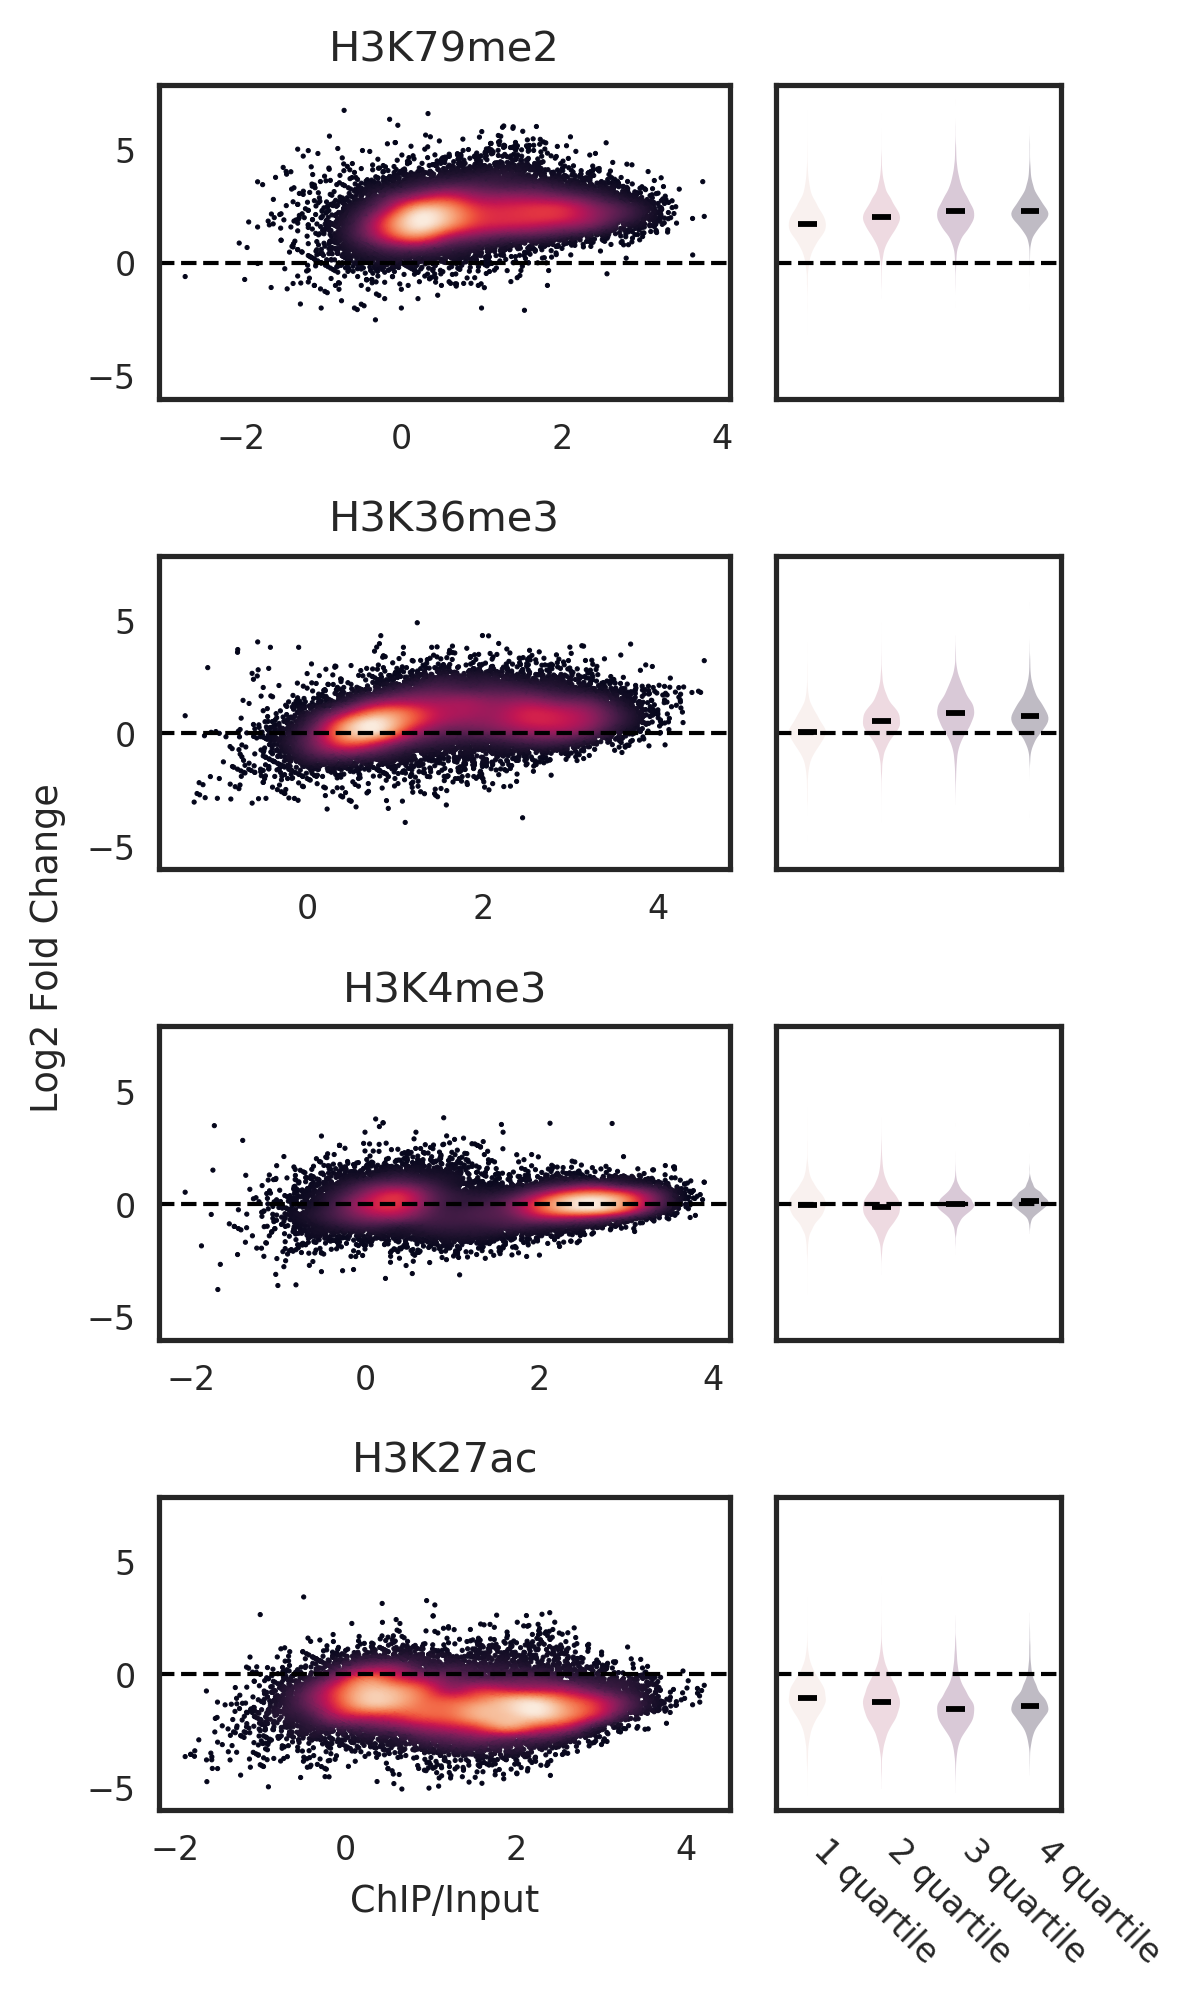

In [10]:
### PLOT (MA PLOT) ###

fig,ax = plt.subplots(4,2,dpi=300, figsize=(4.5,7), sharey=True, gridspec_kw = {'width_ratios':[8,4]})
reg=False
# ax[0][0].set_xlim((-3,6))
H3K79me2, lfc_K79me2, cov_K79me2 = rel.MA_samp(normT_k79me2, ["ESC_DMSO_1+ESC_DMSO_2","NPC48h_DMSO_1+NPC48h_DMSO_2"], reg=reg, ax = ax[0][0])
plot_lfc_quantileCov(cov_K79me2,lfc_K79me2, q =0.25, ax=ax[0][1])

H3K36me3, lfc_K36me3, cov_K36me3 = rel.MA_samp(normT_k36me3, ["ESC_DMSO_1+ESC_DMSO_2","NPC48h_DMSO_1+NPC48h_DMSO_2"], reg=reg, ax = ax[1][0])
plot_lfc_quantileCov(cov_K36me3,lfc_K36me3, q =0.25, ax=ax[1][1])

H3K4me3, lfc_K4me3, cov_K4me3 = rel.MA_samp(normT_k4me3, ["ESC_DMSO_1+ESC_DMSO_2","NPC48h_DMSO_1+NPC48h_DMSO_2"], reg=reg, ax = ax[2][0])
plot_lfc_quantileCov(cov_K4me3,lfc_K4me3, q =0.25, ax=ax[2][1])

H3K27ac, lfc_K27ac, cov_K27ac = rel.MA_samp(normT_k27ac, ["ESC_DMSO_1+ESC_DMSO_2","NPC48h_DMSO_1+NPC48h_DMSO_2"], reg=reg, ax = ax[3][0])
plot_lfc_quantileCov(cov_K27ac,lfc_K27ac, q =0.25, ax=ax[3][1])

#plt.xlabel("ChIP/Input")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[3][0].set_xlabel("ChIP/Input")
plt.ylabel("Log2 Fold Change")
ax[0][0].set_title("H3K79me2",size=10)
ax[1][0].set_title("H3K36me3",size=10)
ax[2][0].set_title("H3K4me3",size=10)
ax[3][0].set_title("H3K27ac",size=10)
ax[3][1].set_xticks(range(4))
ax[3][1].set_xticklabels(["{} quartile".format(i) for i in range(1,5)], rotation=-45,ha='left')
        
plt.tight_layout()

plt.savefig("../FIGURES/MA_PLOTS_FINAL.png")

